## Tinkering and Testing Some Modules 

<div class="alert alert-info">
<b> I've re-used code from other notebooks/experiments so some pairs of cells, although performing the same task, might be using different modules for it <br>
(eg: cv2.imread() and imageio.imread() are basically the same thing) 
</div>
    

### SSIM to Compute 
- reference vs target $\rightarrow$ once resized and projections have been matched 
- reference (corrected) vs transformed image  
- ground truth vs target $\rightarrow$ match image sizes and projections 
- ground truth (corrected) vs transformed image 

<div class="alert alert-block alert-info">
<b>SSIM
    </div>

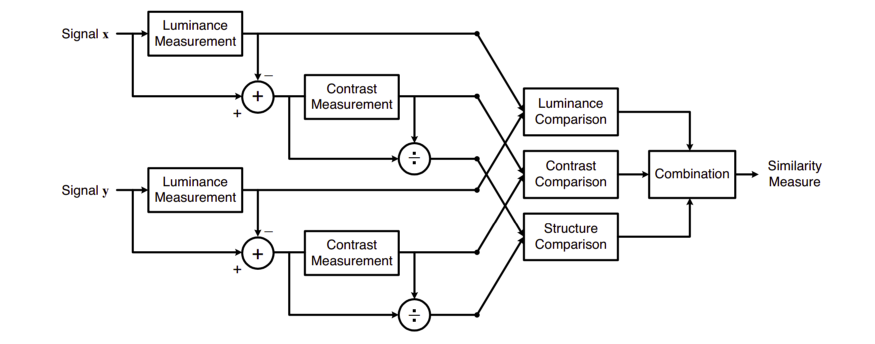

In [1]:
import jupyternotify

In [3]:
import pandas as pd
import xlwt
from xlwt import Workbook
import openpyxl
import xlsxwriter
import os 
import collections 
import numpy as np
import pyssim as ps 

***
### Test Module PIQA for SSIM 

#### `from piqa.ssim import ssim`

In [69]:
import torch

from piqa.ssim import ssim
from piqa.utils.functional import gaussian_kernel

## torch.rand creates a tensor of random numbers as per 
## given params 

x = torch.rand(5, 3, 256, 256)
y = torch.rand(5, 3, 256, 256)

kernel = gaussian_kernel(11, sigma=1.5).repeat(3, 1, 1)

l = ssim(x, y, kernel=kernel, channel_avg=False)
## print (l) GIVES TENSOR OUTPUT! GET THE CONVERTED O/P 

***

### **SSIM Method 1** 

<div class="alert alert-info">
<b>Uses skimage SSIM and OpenCV
    </div> 

#### `from skimage.metrics import structural_similarity`


In [5]:
%%time

from skimage.metrics import structural_similarity
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Wall time: 256 ms


#### Convert 2 imgs to greyscale (ref and tgt) and compute SSIM

In [55]:
%%time 

##before = cv2.imread(r"C:\Users\vasud\OneDrive\Desktop\Test_Images_set_1\1_4.tif")
##after = cv2.imread(r"C:\Users\vasud\OneDrive\Desktop\Test_Images_set_1\3.tif")
## These are reference and target images respectively, gave SSIM Image similarity 0.009843279221469181

##SSIM FOR REF AND TGT IMAGES 

before = cv2.imread(r"C:\Users\vasud\OneDrive\Desktop\Test_Images_set_1\reference\1\tile_0_1024.tif")
after = cv2.imread(r"C:\Users\vasud\OneDrive\Desktop\Test_Images_set_1\target\1\tile_0_1024.tif")

## NORMALIZE 

width = int(before.shape[1])
height = int(before.shape[0])

img_size = (width,height)
after = cv2.resize(after,img_size)

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
print ("Now computing SSIM")
print ()
(score, diff) = structural_similarity(before_gray, after_gray, full=True)

## diff is actually a vector, no need to print 
print ("SSIM computed")

Now computing SSIM

SSIM computed
Wall time: 76 ms


In [56]:
print ("SSIM: {}".format(score))

SSIM: 0.3982660609833839


***
#### <b> Use above method of SSIM in imreg_dft pipeline 

In [8]:
import imreg_dft as ird 
import imageio
import numpy as np 

<div class="alert alert-warning">
<b>AROSICS_image_pair is giving LOWER SSIM for ref_image vs transformed_img as compared to ref_image vs tgt_image ?? 
    </div> 

In [46]:
## TESTING IMREG AND SSIM WITH AROSICS DEVELOPERS SAMPLE IMAGES CAUSE THIS PAIR MOSTLY PRODUCES A STABLE OUTPUT
## AND NEEDS NO RGBA->RGB CONVERSION OR CHANNEL SPLITTING! 

## I SWAPPED IMAGEIO FOR CV2 JUST TO TEST IT, AND THE IMREG_DFT METHOD CRASHED 
## FLAGGED THAT IMAGES MUST BE 2D - MUST BE CONSIDERING THE CHANNEL VARIABLE AS A DIMENSION 
## IMAGEIO MIGHT BE READING THE IMAGE DIFFERENTLY

im0 = imageio.imread(r"C:\Users\vasud\OneDrive\Desktop\Test_Images_set_1\ref_S2A_20160608T153121_T33UUU_sub.tif")
im1 = imageio.imread(r"C:\Users\vasud\OneDrive\Desktop\Test_Images_set_1\tgt_S2A_20160529T153631_T33UUU_sub.tif")

width = int(im1.shape[1])
height = int(im1.shape[0])

img_size = (width,height)
im0 = cv2.resize(im0,img_size)

print (im0.shape)
print (im1.shape)

(3152, 2074)
(3152, 2074)


In [47]:
o_score,o_diff= structural_similarity(im0, im1, full=True)
print ("SSIM for ref and tgt img: {}".format(o_score)) 

SSIM for ref and tgt img: 0.7536433375272917


In [64]:
%%time 
result = ird.similarity(im0, im1, numiter=1)

Wall time: 30.5 s


In [66]:
result['success']

0.018092789599697554

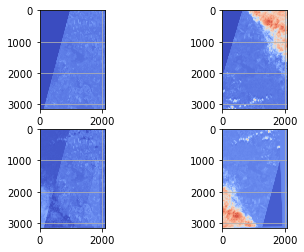

In [74]:
import matplotlib.pyplot as plt

timg = result['timg']
timg_save = cv2.imwrite("timg.tif",timg)  
ird.imshow(im0, im1, timg)
plt.show()

In [71]:
print("t_img is of type {}".format(type(timg))) 
print ()
print ("reference image is of type {}".format(type(im0))) 
## IF YOU LOAD ONE THING WITH CV2 AND OTHER WITH IMAGEIO OR NUMPY 
## THE DATA TYPES WILL DIFFER! MAYBE SSIM WILL BE AFFECTED! 
## <class 'numpy.ndarray'> <class 'imageio.core.util.Array'> DIFF!

t_img is of type <class 'numpy.ndarray'>

reference image is of type <class 'numpy.ndarray'>


******
- **The result of imageio.imread is already a NumPy array**

- **imageio.core.util.Image** is an ndarray subclass that exists primarily so the array can have a meta attribute holding image metadata.

- If you want an object of type exactly numpy.ndarray, you can use `asarray`: 

`array = numpy.asarray(img)`


In [62]:
timg = np.asarray(timg) 

In [52]:
(score, diff) = structural_similarity(im0,timg,full=True)
## STILL SAYING 'MISMATCHED DATA TYPE ? Y  T_T 
print ()
print("Image similarity", score)
print ()
print ("SSIM computed")                                                                     

C:\Users\vasud\.conda\envs\coreg_build\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.



Image similarity 0.6983060174025799

SSIM computed


In [53]:
(score, diff) = structural_similarity(im0, im1, full=True)
print ()
print("Image similarity", score)
print ()
print ("SSIM computed")   


Image similarity 0.7536433375272917

SSIM computed


In [54]:
(score, diff) = structural_similarity(im1, timg, full=True)
print ()
print("Image similarity", score)
print ()
print ("SSIM computed")   

C:\Users\vasud\.conda\envs\coreg_build\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.



Image similarity 0.7332043662465608

SSIM computed


- `The diff image contains the actual image differences between the two images and is represented as a floating point data type in the range [0,1]` 
<br>
- `so we must convert the array to 8-bit unsigned integers in the range [0,255] before we can use it with OpenCV`

In [18]:
diff = (diff * 255).astype("uint8")

- Threshold the difference image, followed by finding contours to obtain the regions of the two input images that differ

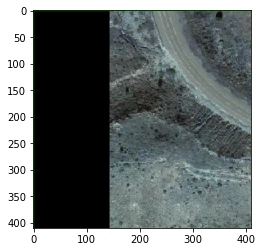

In [19]:
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype='uint8')
filled_after = after.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled_after, [c], 0, (0,255,0), -1)

plt.imshow(before)
plt.show()       

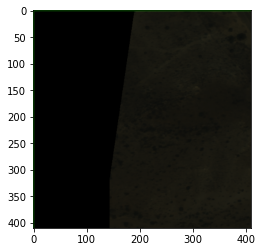

In [20]:
plt.imshow(after)
plt.show() 

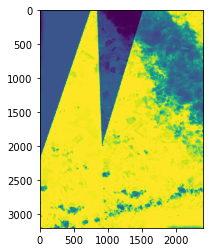

In [21]:
plt.imshow(diff)
plt.show() 

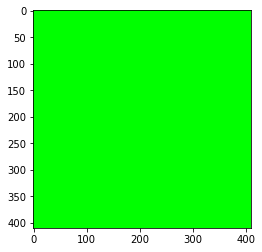

In [22]:
plt.imshow(filled_after)
plt.show() 

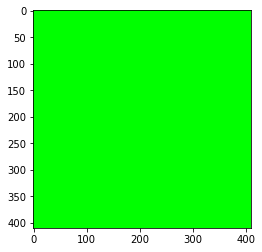

In [23]:
plt.imshow(mask)
plt.show() 

***

### **SSIM Method 2**

In [24]:
# Usage:
#
# python3 script.py --input original.png --output modified.png
# Based on: https://github.com/mostafaGwely/Structural-Similarity-Index-SSIM-

# 1. Import the necessary packages
from skimage.measure import compare_ssim
import argparse
import imutils
import cv2

# 2. Construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-f", "--first", required=True, help="Directory of the image that will be compared")
# ap.add_argument("-s", "--second", required=True, help="Directory of the image that will be used to compare")
# args = vars(ap.parse_args())

# 3. Load the two input images
imageA = im0
imageB = im1

In [68]:
# 4. Convert the images to grayscale
# grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
# grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
import sys
# 5. Compute the Structural Similarity Index (SSIM) between the two
#    images, ensuring that the difference image is returned
(score, diff) = compare_ssim(im0, im1, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))

C:\Users\vasud\.conda\envs\coreg_build\lib\site-packages\ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys


SSIM: 0.7536433375272917


***

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
import argparse

def options():
	parser = argparse.ArgumentParser(description="Read image metadata")
	parser.add_argument("-o", "--first", help="Input image file.", required=True)
	parser.add_argument("-c", "--second", help="Input image file.", required=True)
	args = parser.parse_args()
	return args

def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
	mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	mse_error /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE. The lower the error, the more "similar" the two images are.
	return mse_error

def compare(imageA, imageB):
	# Calculate the MSE and SSIM
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB)

	# Return the SSIM. The higher the value, the more "similar" the two images are.
	return s

def main(): 

	# Get options
	args = options()

	# Import images
	image1 = cv2.imread(args.first)
	image2 = cv2.imread(args.second, 1)

	# Convert the images to grayscale
	gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
	gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

	# Check for same size and ratio and report accordingly
	ho, wo, _ = image1.shape
	hc, wc, _ = image2.shape
	ratio_orig = ho/wo
	ratio_comp = hc/wc
	dim = (wc, hc)

	if round(ratio_orig, 2) != round(ratio_comp, 2):
		print("\nImages not of the same dimension. Check input.")
		exit()

	# Resize first image if the second image is smaller
	elif ho > hc and wo > wc:
		print("\nResizing original image for analysis...")
		gray1 = cv2.resize(gray1, dim)

	elif ho < hc and wo < wc:
		print("\nCompressed image has a larger dimension than the original. Check input.")
		exit()

	if round(ratio_orig, 2) == round(ratio_comp, 2):

		mse_value = mse(gray1, gray2)
		ssim_value = compare(gray1, gray2)
		print("MSE:", mse_value)
		print("SSIM:", ssim_value)